## 1. This is for loading, cleaning data and plotting up in 2D and 3D

In [1]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import numpy as np
import warnings
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

BIT_DIAMETER = 8.5

def read_file(file_name, file_type='csv', encoding=None):
    if not encoding:
        encoding = 'utf-8'

    if file_type == 'csv':
        # Read the file with no header
        df = pd.read_csv(file_name, header=None, encoding=encoding)
    elif file_type == 'excel':
        # Read the file with no header
        df = pd.read_excel(file_name, header=None, encoding=encoding)
    elif file_type == 'txt':
        # Read the file with no header
        df = pd.read_csv(file_name, header=None, delimiter='\t', encoding=encoding)
    return df

def read_and_process_file(file_name, file_type='csv'):

    well_name = file_name.split('.')[-2].split('/')[-1].split('\\')[-1]
    file_type = file_name.split('.')[-1]

    try:
        df = read_file(file_name, file_type)
    except UnicodeDecodeError:
        df = read_file(file_name, file_type, 'latin-1')

    # Combine the first two rows to create the header
    header = df.iloc[0].str.strip() + '__' + df.iloc[1].str.strip()

    # Remove the first two rows
    df = df.iloc[2:]

    # Set the new header
    df.columns = header

    df["well"] = well_name

    # Print out the new column names
    print(df.columns)

    return df


def clean_df(df, columns):
    # Drop rows where all specified columns are 0
    for column in columns:
        df = df[df[column] != 0]

    # Convert specified columns to numeric and handle non-numeric values
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Replace -999.25 with NaN
    df = df.replace(-999.25, np.nan)

    # Drop rows where any specified column is NaN
    df = df.dropna(subset=columns)

    # Remove columns MSE__ksi if df has
    if 'MSE__ksi' in df.columns:
        df = df.drop('MSE__ksi', axis=1)

    # Add column BIT_DIAMETER__in
    df["BIT_DIAMETER__in"] = BIT_DIAMETER

    # # Add column Mu with formula Mu=TORQ_AVG__kLbf.ft/(WOB_AVG__tf * 2.2 * BIT_DIAMETER__in / 36)
    # df["Mu"] = df["TORQ_AVG__kLbf.ft"] / (
    #     df["WOB_AVG__tf"] * 2.2 * df["BIT_DIAMETER"] / 36
    # )

    return df

def remove_outliers(df, columns, cleaned_df=False):

    if not cleaned_df:
        df = clean_df(df, columns)

    for column in columns:
        # Convert specified columns to numeric and handle non-numeric values
        df[column] = pd.to_numeric(df[column], errors='coerce')

        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[column] >= Q1 - 1.5*IQR) &
                (df[column] <= Q3 + 1.5*IQR)]
        
    return df


def plot_3d_scatter(df, x_col, y_col, z_col, color_col=None, size_col=None, width=800, height=800, marker_size=3):
    # Create a copy of the dataframe and round the columns
    round_num = 2

    df_copy = df.copy()
    df_copy[x_col] = pd.to_numeric(df_copy[x_col], errors='coerce').round(round_num)
    df_copy[y_col] = pd.to_numeric(df_copy[y_col], errors='coerce').round(round_num)
    df_copy[z_col] = pd.to_numeric(df_copy[z_col], errors='coerce').round(round_num)

    fig = px.scatter_3d(df_copy, x=x_col, y=y_col, z=z_col,
                        color=color_col, size=size_col)
    fig.update_traces(marker=dict(size=marker_size))
    fig.update_layout(width=width, height=height)

    # Update the starting point of each axis to 0
    # fig.update_scenes(xaxis=dict(range=[0, df_copy[x_col].max()*1.2]),
    #                   yaxis=dict(range=[0, df_copy[y_col].max()*1.2]),
    #                   zaxis=dict(range=[0, df_copy[z_col].max()*1.2]))
    fig.update_scenes(xaxis=dict(range=[df_copy[x_col].min(), df_copy[x_col].max()*1.2]),
                      yaxis=dict(range=[df_copy[y_col].min(),
                                 df_copy[y_col].max()*1.2]),
                      zaxis=dict(range=[df_copy[z_col].min(), df_copy[z_col].max()*1.2]))
    
    fig.show()


def plot_2d_scatter(df, x_col, y_col, color_col=None, size_col=None, width=800, height=800, marker_size=5):
    # Create a copy of the dataframe and round the columns
    round_num = 2

    df_copy = df.copy()
    df_copy[x_col] = pd.to_numeric(
        df_copy[x_col], errors='coerce').round(round_num)
    df_copy[y_col] = pd.to_numeric(
        df_copy[y_col], errors='coerce').round(round_num)
    
    fig = px.scatter(df_copy, x=x_col, y=y_col, color=color_col, size=size_col)
    fig.update_traces(marker=dict(size=marker_size))
    fig.update_layout(width=width, height=height)

    # Update the starting point of each axis to 0
    fig.update_scenes(xaxis=dict(range=[0, df_copy[x_col].max()*1.2]),
                      yaxis=dict(range=[0, df_copy[y_col].max()*1.2]))

    fig.show()

## 2. Cluster data
Experiment is showing that 'DOC__in/rev', 'TORQ_AVG__kLbf.ft', 'WOB_AVG__tf' give the most reasonable clusters with this data set.

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler


def perform_kmeans(df, columns, k=None):

    # Extract the columns for clustering
    data = df[columns]

    # Scale the data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    if k is None:
        # List to hold the silhouette scores for each k
        silhouette_scores = []

        # Test k from 2 to 10 (silhouette score requires at least 2 clusters)
        for k in range(2, 11):
            kmeans = KMeans(n_clusters=k, random_state=1)
            kmeans.fit(data)
            score = silhouette_score(data, kmeans.labels_)
            silhouette_scores.append(score)

        # Plot the silhouette scores for each k
        plt.plot(range(2, 11), silhouette_scores, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

        # Find the k with the highest silhouette score
        k = silhouette_scores.index(max(silhouette_scores)) + 2

    # Perform KMeans with the specified or optimal number of clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data)

    # Add the cluster labels to the original DataFrame
    df['cluster'] = kmeans.labels_

    return df

## 3. Model training and Monte Carlo Simulation
- Model is trained with function perform_optimization. After training, the model is used in the Monte Carlo simulation.
- Monte Carlo simulation is used to define the range of min MSE to finally identify MSE min
- Parameters are set extremely high to ensure we can identify the "nearly" MSE min

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler


def perform_optimization(dataframe, k=7):
    # Add the new feature 'Mu'
    dataframe['Mu'] = dataframe['TORQ_AVG__kLbf.ft'] / (dataframe['WOB_AVG__tf'] * 2.2 * 8.5 / 36)

    # Split the dataframe by cluster
    clusters = dataframe['cluster'].unique()
    best_models = {}

    # Initialize KFold for cross-validation
    kfold = KFold(n_splits=k, shuffle=True, random_state=1)

    for cluster in clusters:
        print(f"Evaluating cluster {cluster}")
        cluster_data = dataframe[dataframe['cluster'] == cluster]

        X = cluster_data[['WOB_AVG__tf', 'BITRPM_AVG__rpm', 'TORQ_AVG__kLbf.ft', 'Mu']]
        y = cluster_data['ROPA_AVG__m/h']

        # Normalize the features
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Initialize base models
        models_list = [
            ('rf', RandomForestRegressor(n_estimators=100)),
            ('xgb', XGBRegressor()),
            ('svr', SVR()),
            ('gbm', GradientBoostingRegressor()),
            ('lgbm', LGBMRegressor(verbose=-1)),  # Turn off LightGBM warnings
            ('catboost', CatBoostRegressor(silent=True)),
        ]
        
        best_mse = float('inf')
        best_model = None

        # Perform k-fold cross-validation and print the results for each model
        for model_name, model in models_list:
            model.fit(X, y)
            cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')  # Use 'neg_mean_squared_error'
            cv_scores = -cv_scores  # Convert to positive MSE scores
            print(f"Cross-validation MSE scores for {model_name} in cluster {cluster}: {cv_scores}")
            avg_mse = cv_scores.mean()
            print(f"Average MSE for {model_name} in cluster {cluster}: {avg_mse}\n")

            if avg_mse < best_mse:
                best_mse = avg_mse
                best_model = model

        best_models[cluster] = best_model

    return best_models


# # Example usage
# # Assuming 'data' is your original dataset with the necessary columns
# models_info = perform_optimization(df)

# Continue with the rest of the code for optimization using the evaluated models

In [4]:
import numpy as np
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from tqdm import tqdm
import math

# Constants
BIT_DIAMETER = 8.5
BIT_RADIUS = BIT_DIAMETER / 2

# Bounds for optimization
bounds = {
    'WOB': (1, 100),   # Bounds for WOB (tf)
    'RPM': (150, 200),  # Bounds for RPM (rpm)
    'Torque': (1, 50),  # Bounds for Torque (kLbf-ft)
}

# Function to compute MSE
def compute_mse(wob, rpm, torque, rop):
    wob_term = wob * 2.2 / (BIT_RADIUS * BIT_RADIUS * math.pi)
    torque_term = 480 * torque * rpm / \
        (BIT_DIAMETER * BIT_DIAMETER * rop * 3.2808)
    return wob_term + torque_term


def monte_carlo_optimization(rf_model, iterations):
    def objective_function(params):
        wob, rpm, torque = params
        mu = torque / (wob * 2.2 * BIT_DIAMETER / 36)
        rop = rf_model.predict([[wob, rpm, torque, mu]])  # Use the model to predict rop
        mse = compute_mse(wob, rpm, torque, rop) # Computer mse
        return mse  # We want to minimize MSE

    results = []
    for _ in tqdm(range(iterations)):
        initial_guess = np.array([np.random.uniform(low, high)
                                 for low, high in bounds.values()])
        result = minimize(
            objective_function,
            initial_guess,
            method='L-BFGS-B',
            bounds=list(bounds.values())
        )
        results.append((result.x, result.fun))

    # Extract the parameters and MSEs from the results
    optimized_params = np.array([res[0] for res in results])
    mse_values = np.array([res[1] for res in results])

    # Find the parameters corresponding to the lowest MSEs
    low_mse_threshold = np.percentile(mse_values, 10)
    low_mse_indices = mse_values <= low_mse_threshold
    low_mse_params = optimized_params[low_mse_indices]

    return low_mse_params, mse_values[low_mse_indices]


def get_param_ranges(low_mse_params):
    param_ranges = {
        'WOB': (low_mse_params[:, 0].min(), low_mse_params[:, 0].max()),
        'RPM': (low_mse_params[:, 1].min(), low_mse_params[:, 1].max()),
        'Torque': (low_mse_params[:, 2].min(), low_mse_params[:, 2].max())
        # 'ROP': (low_mse_params[:, 3].min(), low_mse_params[:, 3].max()),
    }
    return param_ranges


# Other functions (print_results, execute_monte_carlo_optimization, add_mse_min_to_original_data) remain the same.
def print_results(cluster, param_ranges, low_mses):
    print(f'Cluster: {cluster}')
    print(f'Parameter Ranges for Low MSE:')
    for param, (low, high) in param_ranges.items():
        print(f'{param}: {low:.2f} to {high:.2f}')
    print(
        f'Corresponding MSE Range: {low_mses.min():.2f} to {low_mses.max():.2f}')
    print()


def execute_monte_carlo_optimization(original_data_with_clusters, iterations):
    print("##### Train Models ######")
    trained_rf_models = perform_optimization(original_data_with_clusters)
    clusters = {}
    for cluster in original_data_with_clusters['cluster'].unique():
        print(f"#### Seeking MSE min for cluster {cluster} #####")
        trained_rf_model = trained_rf_models[cluster]
        low_mse_params, low_mses = monte_carlo_optimization(
            trained_rf_model, iterations)
        param_ranges = get_param_ranges(low_mse_params)
        print_results(cluster, param_ranges, low_mses)
        clusters[int(cluster)] = {
            'param_ranges': param_ranges,
            'low_mses': low_mses,
            'trained_model': trained_rf_model
        }
    return clusters


def add_mse_min_to_original_data(original_data_with_clusters, clusters):
    original_data_with_clusters['MSE_min__ksi'] = original_data_with_clusters['cluster'].map(
        lambda x: clusters[int(x)]['low_mses'].min())
    return original_data_with_clusters

## 4. Misc
When reading the input file, header row and unit row is combined into 1 row. The below is to restore it back to 2 rows for working with other tools such WellCad

In [5]:
def restore_header(df):
    
    # Create a new DataFrame with the same index as the original DataFrame
    new_df = pd.DataFrame(index=df.index)

    # Iterate over the columns of the original DataFrame
    for column in df.columns:
        # Split the column name on "__"
        parts = column.split("__")

        # Add a new column to the new DataFrame
        new_df[parts[0]] = df[column]

    # Insert the second parts of the split as the first row
    new_df.loc[0] = [name.split(
        "__")[-1] if "__" in name else 'nan' for name in df.columns]

    # Reorder the DataFrame so the new row is at the top
    new_df.sort_index(inplace=True)

    return new_df

## 5. Main function:
This is the main function which is running all the function above, the result df include the df with additional columns of MSEmin and cluster

###########################
Reading and processing file...
Index(['DEPMD__ft', 'WOB_AVG__tf', 'DEPTVD__m', 'ROPA_AVG__m/h',
       'TORQ_AVG__kLbf.ft', 'SURFRPM_AVG__rpm', 'MOTORRPM_AVG__rpm',
       'BITRPM_AVG__rpm', 'SPP_AVG__Psi', 'CHKP_AVG__Psi', 'CEMENTP_AVG__Psi',
       'SPM01_AVG__Stk/min', 'SPM02_AVG__Stk/min', 'SPM03_AVG__Stk/min',
       'PITACTIVE_AVG__bbl', 'FLOWIN_AVG__gal/min', 'FLOWOUTP_AVG__%',
       'DIN_AVG__ppg', 'TIN_AVG__C', 'DOUT_AVG__ppg', 'TOUT_AVG__C', 'HP__hp',
       'DOC__in/rev', 'MSE__ksi', 'Comments__TOC/TOP', 'well'],
      dtype='object')
###########################
Cleaning dataframe...
###########################
Removing outliers...
###########################
Performing KMeans clustering...


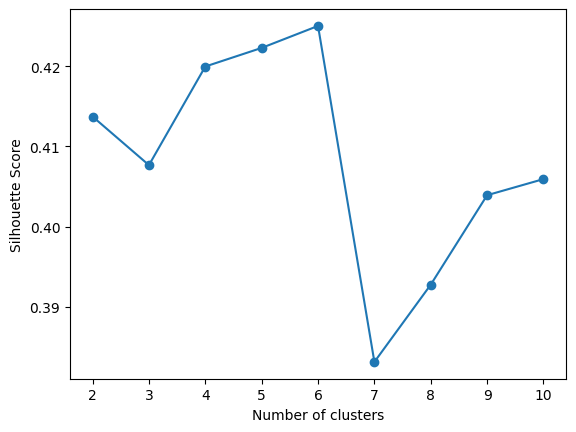

###########################
Executing Monte Carlo optimization...
##### Train Models ######
Evaluating cluster 3
Cross-validation MSE scores for rf in cluster 3: [37.34307064 62.78316785 16.52140432 46.59978269 35.91966625 85.47834714
 33.93313976]
Average MSE for rf in cluster 3: 45.511225520511566

Cross-validation MSE scores for xgb in cluster 3: [ 60.77846122 124.52852556  32.82189297  57.56773463  41.73945027
  89.42154648  43.57205287]
Average MSE for xgb in cluster 3: 64.34709485744932

Cross-validation MSE scores for svr in cluster 3: [ 31.34754348  62.11640812 119.22990971 103.46977637 146.64709748
 107.26395905 201.62546666]
Average MSE for svr in cluster 3: 110.24288012360914

Cross-validation MSE scores for gbm in cluster 3: [ 32.94374772  62.14124874  21.95732639  69.70698013  52.4002019
 100.35445458  45.90808676]
Average MSE for gbm in cluster 3: 55.05886374536141

Cross-validation MSE scores for lgbm in cluster 3: [17.62628029 55.66589326 58.46578023 84.32533208 60.3393

100%|██████████| 100/100 [00:13<00:00,  7.55it/s]


Cluster: 3
Parameter Ranges for Low MSE:
WOB: 1.00 to 1.00
RPM: 150.00 to 150.00
Torque: 1.00 to 1.00
Corresponding MSE Range: 4.44 to 4.44

#### Seeking MSE min for cluster 4 #####


100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


Cluster: 4
Parameter Ranges for Low MSE:
WOB: 1.00 to 1.00
RPM: 150.00 to 150.00
Torque: 1.00 to 1.00
Corresponding MSE Range: 3.27 to 3.27

#### Seeking MSE min for cluster 1 #####


100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Cluster: 1
Parameter Ranges for Low MSE:
WOB: 6.12 to 9.23
RPM: 150.00 to 150.00
Torque: 1.00 to 1.00
Corresponding MSE Range: 4.89 to 4.95

#### Seeking MSE min for cluster 5 #####


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


Cluster: 5
Parameter Ranges for Low MSE:
WOB: 1.00 to 1.54
RPM: 150.00 to 150.00
Torque: 1.00 to 1.00
Corresponding MSE Range: 4.54 to 4.61

#### Seeking MSE min for cluster 2 #####


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Cluster: 2
Parameter Ranges for Low MSE:
WOB: 1.00 to 2.20
RPM: 150.00 to 150.00
Torque: 1.00 to 1.00
Corresponding MSE Range: 3.24 to 3.30

#### Seeking MSE min for cluster 0 #####


100%|██████████| 100/100 [00:15<00:00,  6.57it/s]

Cluster: 0
Parameter Ranges for Low MSE:
WOB: 1.00 to 1.00
RPM: 150.00 to 150.00
Torque: 1.00 to 1.00
Corresponding MSE Range: 4.49 to 4.49

###########################
Adding MSE min to original data...
###########################
Restoring header...
###########################
Done.


In [7]:
# Final function to combine read file, clean df, remove outliers, perform k-mean clustering,
# perform monte carlo optimization and add mse min to original dataframe
def main(data_file_path, columns_to_clean, column_to_remove_outliers, columns_for_clustering, k_clusters, iterations=100):
    print("###########################")
    print("Reading and processing file...")
    df = read_and_process_file(data_file_path)

    print("###########################")
    print("Cleaning dataframe...")
    df = clean_df(df, columns_to_clean)

    print("###########################")
    print("Removing outliers...")
    df = remove_outliers(df, column_to_remove_outliers)

    print("###########################")
    print("Performing KMeans clustering...")
    df = perform_kmeans(df, columns_for_clustering, k_clusters)

    print("###########################")
    print("Executing Monte Carlo optimization...")
    clusters = execute_monte_carlo_optimization(df, iterations)

    print("###########################")
    print("Adding MSE min to original data...")
    df = add_mse_min_to_original_data(df, clusters)

    print("###########################")
    print("Restoring header...")
    df_new = restore_header(df)

    print("###########################")
    print("Done.")
    return df, df_new, clusters


data_file_path = './G7.csv'
# columns_to_clean = ['DOC__in/rev', 'BITRPM_AVG__rpm', 'ROPA_AVG__m/h',
#                     'TORQ_AVG__kLbf.ft', 'WOB_AVG__tf', 'MSE__ksi']
columns_to_clean = ['DOC__in/rev', 'BITRPM_AVG__rpm', 'ROPA_AVG__m/h',
                    'TORQ_AVG__kLbf.ft', 'WOB_AVG__tf']
columns_to_remove_outliers = ['DOC__in/rev', 'TORQ_AVG__kLbf.ft']
columns_for_clustering = ['DOC__in/rev', 
                          'TORQ_AVG__kLbf.ft', 'WOB_AVG__tf']
# columns_for_clustering = ['DOC__in/rev', 'BITRPM_AVG__rpm', 'ROPA_AVG__m/h',
#                           'TORQ_AVG__kLbf.ft', 'WOB_AVG__tf']
k_clusters = None
iterations = 100
df, df_new, clusters = main(data_file_path, columns_to_clean,
          columns_to_remove_outliers, columns_for_clustering, k_clusters, iterations)

In [45]:
df[0]

,DEPMD__ft,WOB_AVG__tf,DEPTVD__m,ROPA_AVG__m/h,TORQ_AVG__kLbf.ft,SURFRPM_AVG__rpm,MOTORRPM_AVG__rpm,BITRPM_AVG__rpm,SPP_AVG__Psi,CHKP_AVG__Psi,...,DOUT_AVG__ppg,TOUT_AVG__C,HP__hp,DOC__in/rev,Comments__TOC/TOP,well,BIT_DIAMETER__in,cluster,Mu,MSE_min__ksi
6,2671,3.68,2536.87,54.78,4.54,48,0,48.0,676,0,...,11.69,34.7,41.49276466,0.748852,TOC,G7,8.5,3,2.375029,4.437026
22,2687,1.31,2550.4,64.94,4.77,48,0,48.0,862,0,...,11.69,34.4,43.59482102,0.887741,TOC,G7,8.5,4,7.009838,3.064289
23,2688,1.30,2551.26,64.30,4.74,48,0,48.0,865,0,...,11.7,34.5,43.32063976,0.878992,TOC,G7,8.5,4,7.019334,3.064289
24,2689,1.30,2552.1,66.09,4.73,48,0,48.0,865,0,...,11.7,34.5,43.229246,0.903461,TOC,G7,8.5,4,7.004525,3.064289
25,2690,1.30,2552.95,66.49,4.71,48,0,48.0,866,0,...,11.7,34.6,43.04645849,0.908929,TOC,G7,8.5,4,6.974907,3.064289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,3666,1.08,3393.95,82.52,6.00,75,0,74.7,1455,0,...,11.7,53.6,85.33891851,0.724859,TOP,G7,8.5,0,10.695187,4.488222
1010,3667,1.08,3394.84,67.75,6.00,75,0,74.6,1457,0,...,11.7,53.6,85.22467631,0.595917,TOP,G7,8.5,0,10.695187,4.488222
1011,3668,1.08,3395.65,64.46,6.00,75,0,74.7,1460,0,...,11.7,53.6,85.33891851,0.566219,TOP,G7,8.5,0,10.695187,4.488222
1012,3669,1.08,3396.52,60.13,6.00,75,0,74.6,1459,0,...,11.7,53.6,85.22467631,0.528893,TOP,G7,8.5,0,10.695187,4.488222


In [46]:
plot_3d_scatter(df[0], 'WOB_AVG__tf',   'DOC__in/rev', 'TORQ_AVG__kLbf.ft', 'cluster')

In [24]:
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.metrics import make_scorer

# # Define a custom scorer based on MSE, if necessary


# def mse_scorer(y_true, y_pred):
#     mse = np.mean((y_true - y_pred) ** 2)
#     return mse


# # Custom MSE scorer for cross-validation
# custom_scorer = make_scorer(mse_scorer, greater_is_better=False)

# # Function to perform k-fold cross-validation and model evaluation


# def evaluate_model(data, k=5):
#     # Split the data by cluster
#     clusters = data['cluster'].unique()
#     models = {}

#     for cluster in clusters:
#         print(f"Evaluating cluster {cluster}")
#         cluster_data = data[data['cluster'] == cluster]

#         X = cluster_data[['WOB_AVG__tf',
#                           'BITRPM_AVG__rpm', 'TORQ_AVG__kLbf.ft']]
#         y = cluster_data['ROPA_AVG__m/h']

#         # Initialize Random Forest model
#         rf_model = RandomForestRegressor()

#         # Perform k-fold cross-validation
#         kf = KFold(n_splits=k, shuffle=True, random_state=1)
#         cv_scores = cross_val_score(
#             rf_model, X, y, cv=kf, scoring=custom_scorer)

#         # Fit the model on the entire cluster data
#         rf_model.fit(X, y)

#         # Store the model and cross-validation scores
#         models[cluster] = {
#             'model': rf_model,
#             'cv_scores': cv_scores,
#             'mean_cv_score': np.mean(cv_scores)
#         }

#         # Print the results of the evaluation
#         print(
#             f"Cross-validation MSE scores for cluster {cluster}: {cv_scores}")
#         print(f"Average MSE for cluster {cluster}: {np.mean(cv_scores)}\n")

#     return models

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

def evaluate_model(dataframe, k=7):
    # Add the new feature 'Mu'
    dataframe['Mu'] = dataframe['TORQ_AVG__kLbf.ft'] / (dataframe['WOB_AVG__tf'] * 2.2 * 8.5 / 36)

    # Split the dataframe by cluster
    clusters = dataframe['cluster'].unique()
    best_models = {}

    # Initialize KFold for cross-validation
    kfold = KFold(n_splits=k, shuffle=True, random_state=1)

    for cluster in clusters:
        print(f"Evaluating cluster {cluster}")
        cluster_data = dataframe[dataframe['cluster'] == cluster]

        X = cluster_data[['WOB_AVG__tf', 'BITRPM_AVG__rpm', 'TORQ_AVG__kLbf.ft', 'Mu']]
        y = cluster_data['ROPA_AVG__m/h']

        # Normalize the features
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Initialize base models
        models_list = [
            ('rf', RandomForestRegressor(n_estimators=100)),
            ('xgb', XGBRegressor()),
            ('svr', SVR()),
            ('gbm', GradientBoostingRegressor()),
            ('lgbm', LGBMRegressor(verbose=-1)),  # Turn off LightGBM warnings
            ('catboost', CatBoostRegressor(silent=True)),
        ]
        
        best_mse = float('inf')
        best_model = None

        # Perform k-fold cross-validation and print the results for each model
        for model_name, model in models_list:
            model.fit(X, y)
            cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')  # Use 'neg_mean_squared_error'
            cv_scores = -cv_scores  # Convert to positive MSE scores
            print(f"Cross-validation MSE scores for {model_name} in cluster {cluster}: {cv_scores}")
            avg_mse = cv_scores.mean()
            print(f"Average MSE for {model_name} in cluster {cluster}: {avg_mse}\n")

            if avg_mse < best_mse:
                best_mse = avg_mse
                best_model = model

        best_models[cluster] = best_model

    return best_models


# Example usage
# Assuming 'data' is your original dataset with the necessary columns
models_info = evaluate_model(df)

# Continue with the rest of the code for optimization using the evaluated models

Evaluating cluster 3
Cross-validation MSE scores for rf in cluster 3: [45.1479914  65.48627795 17.318422   50.72760363 35.39113279 82.31514972
 36.30357176]
Average MSE for rf in cluster 3: 47.52716417817622

Cross-validation MSE scores for xgb in cluster 3: [ 60.77846122 124.52852556  32.82189297  57.56773463  41.73945027
  89.42154648  43.57205287]
Average MSE for xgb in cluster 3: 64.34709485744932

Cross-validation MSE scores for svr in cluster 3: [ 31.34754348  62.11640812 119.22990971 103.46977637 146.64709748
 107.26395905 201.62546666]
Average MSE for svr in cluster 3: 110.24288012360914

Cross-validation MSE scores for gbm in cluster 3: [ 33.05687186  68.44231868  20.9806074   66.80316908  52.14447324
 100.35445458  46.0447939 ]
Average MSE for gbm in cluster 3: 55.403812677179

Cross-validation MSE scores for lgbm in cluster 3: [17.62628029 55.66589326 58.46578023 84.32533208 60.33937796 83.14776436
 38.17076804]
Average MSE for lgbm in cluster 3: 56.82017088979385

Cross-val

In [22]:
models_info

{3: <catboost.core.CatBoostRegressor at 0x29eb5cf3d30>,
 4: <catboost.core.CatBoostRegressor at 0x29eb5cf3eb0>,
 1: <catboost.core.CatBoostRegressor at 0x29eb5cf0c70>,
 5: XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 2: RandomForestRegressor(),
 0: <catboost.core.CatBoostRegressor at 0

In [14]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

def evaluate_model(data, k=5):
    # Add the new feature 'Mu'
    data['Mu'] = data['TORQ_AVG__kLbf.ft'] / (data['WOB_AVG__tf'] * 2.2 * 8.5 / 36)

    # Split the data by cluster
    clusters = data['cluster'].unique()
    models = {}

    # Initialize KFold for cross-validation
    kfold = KFold(n_splits=k, shuffle=True, random_state=1)

    for cluster in clusters:
        print(f"Evaluating cluster {cluster}")
        cluster_data = data[data['cluster'] == cluster]

        X = cluster_data[['WOB_AVG__tf', 'BITRPM_AVG__rpm', 'TORQ_AVG__kLbf.ft', 'Mu']]
        y = cluster_data['ROPA_AVG__m/h']

        # Normalize the features
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Initialize base models
        rf_model = RandomForestRegressor(n_estimators=100)
        xgb_model = XGBRegressor()
        svr_model = SVR()

        # Initialize VotingRegressor
        voting_model = VotingRegressor(estimators=[('rf', rf_model), ('xgb', xgb_model), ('svr', svr_model)])

        # Perform k-fold cross-validation and print the results for each model
        for model_name, model in voting_model.estimators:
            model.fit(X, y)
            cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
            print(f"Cross-validation MSE scores for {model_name} in cluster {cluster}: {cv_scores}")
            print(f"Average MSE for {model_name} in cluster {cluster}: {cv_scores.mean()}\n")

        # Fit the model on the entire cluster data
        voting_model.fit(X, y)

        # Perform k-fold cross-validation for the VotingRegressor
        cv_scores = cross_val_score(voting_model, X, y, cv=kfold, scoring='neg_mean_squared_error')

        # Store the model and cross-validation scores
        models[cluster] = {
            'model': voting_model,
            'cv_scores': cv_scores,
            'mean_cv_score': cv_scores.mean()
        }

        # Print the results of the evaluation for the VotingRegressor
        print(f"Cross-validation MSE scores for VotingRegressor in cluster {cluster}: {cv_scores}")
        print(f"Average MSE for VotingRegressor in cluster {cluster}: {cv_scores.mean()}\n")

    return models


models_info = evaluate_model(df)

Evaluating cluster 0
Cross-validation MSE scores for rf in cluster 0: [-54.40011593 -69.6438097  -66.27438068 -67.51779044 -85.47417447]
Average MSE for rf in cluster 0: -68.66205424269137

Cross-validation MSE scores for xgb in cluster 0: [ -61.29819385  -83.65256101 -107.01943053  -76.60787525 -104.31036266]
Average MSE for xgb in cluster 0: -86.57768466060392

Cross-validation MSE scores for svr in cluster 0: [-185.28205632 -162.99408652 -215.48583417 -163.61871245 -133.51849947]
Average MSE for svr in cluster 0: -172.17983778552977

Cross-validation MSE scores for VotingRegressor in cluster 0: [-65.94495095 -74.65612188 -96.19564088 -75.99483157 -68.24359142]
Average MSE for VotingRegressor in cluster 0: -76.20702734031642

Evaluating cluster 2
Cross-validation MSE scores for rf in cluster 2: [-83.25067489 -81.52976161 -68.66284168 -40.12053452 -76.00149935]
Average MSE for rf in cluster 2: -69.91306241126703

Cross-validation MSE scores for xgb in cluster 2: [-99.94504568 -87.3167

In [12]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

def evaluate_model(data, k=5):
    # Split the data by cluster
    clusters = data['cluster'].unique()
    models = {}

    # Initialize KFold for cross-validation
    kfold = KFold(n_splits=k, shuffle=True, random_state=1)

    for cluster in clusters:
        print(f"Evaluating cluster {cluster}")
        cluster_data = data[data['cluster'] == cluster]

        X = cluster_data[['WOB_AVG__tf', 'BITRPM_AVG__rpm', 'TORQ_AVG__kLbf.ft', 'Mu']]
        y = cluster_data['ROPA_AVG__m/h']

        # Normalize the features
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Initialize base models
        rf_model = RandomForestRegressor(n_estimators=100)
        xgb_model = XGBRegressor()
        svr_model = SVR()

        # Initialize VotingRegressor
        voting_model = VotingRegressor(estimators=[('rf', rf_model), ('xgb', xgb_model), ('svr', svr_model)])

        # Perform k-fold cross-validation
        cv_scores = cross_val_score(voting_model, X, y, cv=kfold, scoring='neg_mean_squared_error')

        # Fit the model on the entire cluster data
        voting_model.fit(X, y)

        # Store the model and cross-validation scores
        models[cluster] = {
            'model': voting_model,
            'cv_scores': cv_scores,
            'mean_cv_score': cv_scores.mean()
        }

        # Print the results of the evaluation
        print(f"Cross-validation MSE scores for cluster {cluster}: {cv_scores}")
        print(f"Average MSE for cluster {cluster}: {cv_scores.mean()}\n")

    return models


models_info = evaluate_model(df)

Evaluating cluster 0
Cross-validation MSE scores for cluster 0: [-65.70416338 -74.79860757 -95.45457204 -76.78148065 -68.88223135]
Average MSE for cluster 0: -76.32421099918555

Evaluating cluster 2
Cross-validation MSE scores for cluster 2: [-81.81918797 -94.01715619 -72.91317922 -44.62773874 -85.49880957]
Average MSE for cluster 2: -75.77521433752335

Evaluating cluster 1
Cross-validation MSE scores for cluster 1: [-52.20886384 -67.65803184 -69.85317807 -67.77587774 -79.20641422]
Average MSE for cluster 1: -67.34047314119599



In [21]:
df.describe()

,WOB_AVG__tf,ROPA_AVG__m/h,TORQ_AVG__kLbf.ft,BITRPM_AVG__rpm,DOC__in/rev,BIT_DIAMETER__in,cluster
count,956.000000,956.000000,956.000000,956.000000,956.000000,956.0,956.000000
mean,1.223264,72.635021,5.539351,74.957218,0.637355,8.5,1.179916
std,0.452838,14.359668,0.426401,5.008577,0.124793,0.0,0.774633
min,0.280000,34.390000,4.540000,48.000000,0.324630,8.5,0.000000
25%,0.980000,63.935000,5.170000,75.000000,0.557199,8.5,1.000000
50%,1.110000,72.095000,5.630000,76.000000,0.628799,8.5,1.000000
75%,1.462500,80.415000,5.950000,76.000000,0.706525,8.5,2.000000
max,3.680000,109.880000,7.000000,77.000000,0.937889,8.5,2.000000


In [18]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Define a list of models to evaluate
models_to_evaluate = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regression': SVR()
}

# Function to perform k-fold cross-validation and model evaluation


def evaluate_models(data, k=5):
    # Split the data by cluster
    clusters = data['cluster'].unique()
    best_models = {}

    for cluster in clusters:
        best_score = float('inf')
        best_model_name = None
        best_model = None

        print(f"Evaluating models for cluster {cluster}")
        cluster_data = data[data['cluster'] == cluster]

        X = cluster_data[['WOB_AVG__tf',
                          'BITRPM_AVG__rpm', 'TORQ_AVG__kLbf.ft']]
        y = cluster_data['ROPA_AVG__m/h']

        for model_name, model in models_to_evaluate.items():
            # Perform k-fold cross-validation
            kf = KFold(n_splits=k, shuffle=True, random_state=1)
            cv_scores = cross_val_score(
                model, X, y, cv=kf, scoring='neg_mean_squared_error')
            # Negate to convert to positive MSE
            mean_cv_score = -np.mean(cv_scores)

            # Print the results of the evaluation
            print(f"{model_name} - CV MSE: {mean_cv_score}")

            # Update the best model if this model performed better
            if mean_cv_score < best_score:
                best_score = mean_cv_score
                best_model_name = model_name
                best_model = model

        # Fit the best model on the entire cluster data
        best_model.fit(X, y)

        # Store the best model and its cross-validation score
        best_models[cluster] = {
            'model': best_model,
            'model_name': best_model_name,
            'cv_score': best_score
        }

        print(
            f"Best model for cluster {cluster}: {best_model_name} with MSE: {best_score}\n")

    return best_models


# Example usage
# Assuming 'data' is your original dataset with the necessary columns
best_models_info = evaluate_models(df)

# You can now proceed with the rest of the code for optimization using the best models

Evaluating models for cluster 0
Linear Regression - CV MSE: 186.47092650904943
Random Forest - CV MSE: 66.40407267324315
Gradient Boosting - CV MSE: 58.681483708534515
Support Vector Regression - CV MSE: 256.95355290779264
Best model for cluster 0: Gradient Boosting with MSE: 58.681483708534515

Evaluating models for cluster 2
Linear Regression - CV MSE: 210.40023897787538
Random Forest - CV MSE: 66.73835097438982
Gradient Boosting - CV MSE: 69.72389424473728
Support Vector Regression - CV MSE: 218.32159927558573
Best model for cluster 2: Random Forest with MSE: 66.73835097438982

Evaluating models for cluster 1
Linear Regression - CV MSE: 85.62004230342218
Random Forest - CV MSE: 69.09040435250529
Gradient Boosting - CV MSE: 67.95785738701136
Support Vector Regression - CV MSE: 94.50777341056725
Best model for cluster 1: Gradient Boosting with MSE: 67.95785738701136



In [19]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import logging

# Suppress TensorFlow logging, except for errors
tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel(logging.CRITICAL)



# Define a function to create the Keras-based neural network model


def create_nn_model(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Wrap the Keras model as a scikit-learn compatible estimator
nn_model = KerasRegressor(model=create_nn_model,
                          input_dim=3, epochs=100, batch_size=10, verbose=0)

# The rest of your code can remain the same.


# Define a list of models to evaluate
models_to_evaluate = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regression': SVR(),
    'Neural Network': nn_model
}

# Function to evaluate models


def evaluate_models(data, k=5):
    # Split the data by cluster
    clusters = data['cluster'].unique()
    best_models = {}

    for cluster in clusters:
        best_score = float('inf')
        best_model_name = None
        best_model = None

        print(f"Evaluating models for cluster {cluster}")
        cluster_data = data[data['cluster'] == cluster]

        X = cluster_data[['WOB_AVG__tf',
                          'BITRPM_AVG__rpm', 'TORQ_AVG__kLbf.ft']].values
        y = cluster_data['ROPA_AVG__m/h'].values

        for model_name, model in models_to_evaluate.items():
            # Perform k-fold cross-validation
            kf = KFold(n_splits=k, shuffle=True, random_state=1)

            # Special handling for neural network due to its nature
            if model_name == 'Neural Network':
                # Fit the model on the entire dataset (cross-validation is handled differently for NNs)
                model.fit(X, y)
                # You could use a validation split or Keras's cross-validation to evaluate the NN
                pred = model.predict(X)
                mse_score = mean_squared_error(y, pred)
            else:
                mse_score = - \
                    cross_val_score(model, X, y, cv=kf,
                                    scoring='neg_mean_squared_error').mean()

            print(f"{model_name} - CV MSE: {mse_score}")

            if mse_score < best_score:
                best_score = mse_score
                best_model_name = model_name
                best_model = model

        # Fit the best non-neural network model on the entire cluster data
        if best_model_name != 'Neural Network':
            best_model.fit(X, y)

        best_models[cluster] = {
            'model': best_model,
            'model_name': best_model_name,
            'cv_score': best_score
        }

        print(
            f"Best model for cluster {cluster}: {best_model_name} with MSE: {best_score}\n")

    return best_models


# Example usage
# Assuming 'data' is your original dataset with the necessary columns
best_models_info = evaluate_models(df)

# Continue with the rest of the code for optimization using the best models

Evaluating models for cluster 0
Linear Regression - CV MSE: 186.47092650904952
Random Forest - CV MSE: 64.27106252681111
Gradient Boosting - CV MSE: 59.51439972794476
Support Vector Regression - CV MSE: 256.95355290779264
Neural Network - CV MSE: 310.0889334665342
Best model for cluster 0: Gradient Boosting with MSE: 59.51439972794476

Evaluating models for cluster 2
Linear Regression - CV MSE: 210.40023897787546
Random Forest - CV MSE: 67.78733768677537
Gradient Boosting - CV MSE: 69.79603609266123
Support Vector Regression - CV MSE: 218.32159927558573
Neural Network - CV MSE: 358.37832846802337
Best model for cluster 2: Random Forest with MSE: 67.78733768677537

Evaluating models for cluster 1
Linear Regression - CV MSE: 85.62004230342214
Random Forest - CV MSE: 69.75378749868017
Gradient Boosting - CV MSE: 67.3428462474217
Support Vector Regression - CV MSE: 94.50777341056725
Neural Network - CV MSE: 184.27634730177851
Best model for cluster 1: Gradient Boosting with MSE: 67.3428462

In [9]:
# Final function to combine read file, clean df, remove outliers, perform k-mean clustering,
# perform monte carlo optimization and add mse min to original dataframe
def main(data_file_path, columns_to_clean, column_to_remove_outliers, columns_for_clustering, k_clusters, iterations=100):
    df = read_and_process_file(data_file_path)
    df = clean_df(df, columns_to_clean)
    df = remove_outliers(df, column_to_remove_outliers)
    df = perform_kmeans(df, columns_for_clustering, k_clusters)
    clusters = execute_monte_carlo_optimization(df, iterations)
    df = add_mse_min_to_original_data(df, clusters)
    df_new = restore_header(df)
    return df, df_new, clusters

Index(['DEPMD__ft', 'WOB_AVG__tf', 'DEPTVD__m', 'ROPA_AVG__m/h',
       'TORQ_AVG__kLbf.ft', 'SURFRPM_AVG__rpm', 'MOTORRPM_AVG__rpm',
       'BITRPM_AVG__rpm', 'SPP_AVG__Psi', 'CHKP_AVG__Psi', 'CEMENTP_AVG__Psi',
       'SPM01_AVG__Stk/min', 'SPM02_AVG__Stk/min', 'SPM03_AVG__Stk/min',
       'PITACTIVE_AVG__bbl', 'FLOWIN_AVG__gal/min', 'FLOWOUTP_AVG__%',
       'DIN_AVG__ppg', 'TIN_AVG__C', 'DOUT_AVG__ppg', 'TOUT_AVG__C', 'HP__hp',
       'DOC__in/rev', 'MSE__ksi', 'Comments__TOC/TOP', 'well'],
      dtype='object')


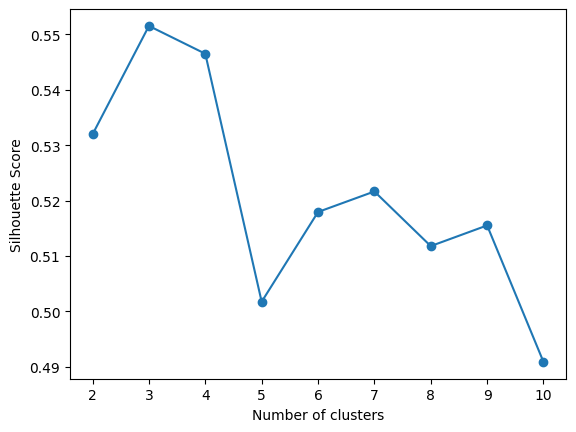

100%|██████████| 100/100 [00:00<00:00, 177.77it/s]


Cluster: 0
Parameter Ranges for Low MSE:
WOB: 1.00 to 1.00
RPM: 150.00 to 150.00
Torque: 1.00 to 1.00
ROP: 1000.00 to 1000.00
Corresponding MSE Range: 0.34 to 0.34



100%|██████████| 100/100 [00:00<00:00, 169.51it/s]


Cluster: 2
Parameter Ranges for Low MSE:
WOB: 1.00 to 1.00
RPM: 150.00 to 150.00
Torque: 1.00 to 1.00
ROP: 1000.00 to 1000.00
Corresponding MSE Range: 0.34 to 0.34



100%|██████████| 100/100 [00:00<00:00, 164.97it/s]


Cluster: 1
Parameter Ranges for Low MSE:
WOB: 1.00 to 1.00
RPM: 150.00 to 150.00
Torque: 1.00 to 1.00
ROP: 1000.00 to 1000.00
Corresponding MSE Range: 0.34 to 0.34



In [26]:
data_file_path = './G7.csv'
# columns_to_clean = ['DOC__in/rev', 'BITRPM_AVG__rpm', 'ROPA_AVG__m/h',
#                     'TORQ_AVG__kLbf.ft', 'WOB_AVG__tf', 'MSE__ksi']
columns_to_clean = ['DOC__in/rev', 'BITRPM_AVG__rpm', 'ROPA_AVG__m/h',
                    'TORQ_AVG__kLbf.ft', 'WOB_AVG__tf', 'MSE__ksi']
columns_to_remove_outliers = ['DOC__in/rev', 'TORQ_AVG__kLbf.ft']
columns_for_clustering = ['DOC__in/rev',
                          'TORQ_AVG__kLbf.ft', 'WOB_AVG__tf']
# columns_for_clustering = ['DOC__in/rev', 'BITRPM_AVG__rpm', 'ROPA_AVG__m/h',
#                           'TORQ_AVG__kLbf.ft', 'WOB_AVG__tf', 'MSE__ksi']
k_clusters = None
iterations = 100
df, df_new, clusters = main(data_file_path, columns_to_clean,
                                   columns_to_remove_outliers, columns_for_clustering, k_clusters, iterations)

## 6. Ongoing work - Identify suggested parameters based on the resulted MSE min to have the highest ROP
- The result_df includes WOB, RPM, TQ, ROP, MSE.
- In the example code, RPM, TQ are constrained and WOB is allow to varied within a range to have highest ROP and MSE closer to MSEmin.
- Plotting up the ROP and WOB is to show their relationship.


In [82]:
from tqdm.notebook import tqdm


def sample_and_evaluate(clusters, constraints, mse_tolerance, num_samples=1000):
    results = []

    for cluster, cluster_data in clusters.items():
        trained_model = cluster_data['trained_model']
        mse_min = cluster_data['low_mses'].min()
        mse_max = mse_min * (1 + mse_tolerance / 100)

        # Wrap the sampling loop with tqdm for the progress bar
        for _ in tqdm(range(num_samples), desc=f"Processing cluster {cluster}"):
            # Sampling parameter values within the constraints
            sampled_params = [
                np.random.uniform(
                    *constraints.get('WOB_AVG__tf', (lower_bound_WOB, upper_bound_WOB))),
                np.random.uniform(
                    *constraints.get('BITRPM_AVG__rpm', (lower_bound_RPM, upper_bound_RPM))),
                np.random.uniform(
                    *constraints.get('TORQ_AVG__kLbf.ft', (lower_bound_Torque, upper_bound_Torque))),
                np.random.uniform(
                    *constraints.get('ROPA_AVG__m/h', (lower_bound_ROPA_AVG, upper_bound_ROPA_AVG))),
            ]

            predicted_mse = trained_model.predict([sampled_params])[0]

            if predicted_mse <= mse_max:
                results.append({
                    'cluster': cluster,
                    'WOB': sampled_params[0],
                    'RPM': sampled_params[1],
                    'Torque': sampled_params[2],
                    'ROP': sampled_params[3],
                    'MSE': predicted_mse,
                    'MSE_min': mse_min
                })

    return pd.DataFrame(results)


constraints = {
    'WOB_AVG__tf': (0, 10),  # Bounds for WOB
    'BITRPM_AVG__rpm': (150, 200),  # Bounds for RPM
    'TORQ_AVG__kLbf.ft': (0, 10),  # Bounds for Torque
    'ROPA_AVG__m/h': (0, 1000),  # Bounds for ROP
}

# Example usage
num_samples = 500  # Number of samples to generate for each cluster
mse_tolerance = 5  # Allow MSE to be within 5% of MSEmin

result_df = sample_and_evaluate(
    clusters, constraints, mse_tolerance, num_samples)
print(result_df)

Processing cluster 0:   0%|          | 0/500 [00:00<?, ?it/s]

Processing cluster 2:   0%|          | 0/500 [00:00<?, ?it/s]

Processing cluster 1:   0%|          | 0/500 [00:00<?, ?it/s]

      cluster       WOB         RPM    Torque         ROP       MSE   MSE_min
0           0  9.117322  180.174232  6.607929  347.473309  8.466915  8.441577
1           0  2.207371  157.549584  6.316647  849.399380  8.466915  8.441577
2           0  9.044418  160.266089  0.792823  347.147407  8.479417  8.441577
3           0  0.990030  198.860214  3.212732  999.899730  8.427439  8.441577
4           0  5.983151  151.889541  4.320672  491.108785  8.479417  8.441577
...       ...       ...         ...       ...         ...       ...       ...
1299        1  9.478902  196.341222  0.521943  932.549872  9.342973  9.342973
1300        1  0.912795  169.336084  0.663957  707.915113  9.714696  9.342973
1301        1  3.861663  175.914954  3.360980  464.284205  9.342973  9.342973
1302        1  8.265227  172.896849  6.406345  802.128698  9.432460  9.342973
1303        1  0.684979  184.511303  1.497348  603.350886  9.726123  9.342973

[1304 rows x 7 columns]


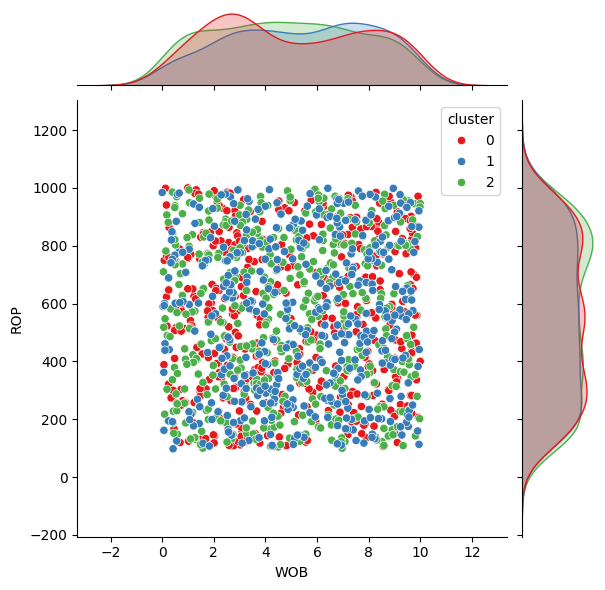

In [83]:
import seaborn as sns
sns.jointplot(data=result_df, x="WOB", y="ROP", hue="cluster", palette="Set1")

## --- End here ---

Some improvement for the above: Quantify the performance of the trained model with the actual dataset => plit dataset to 80/20 for training and testing.

Below is just for experiment

The results you're getting suggest that the optimization process is consistently finding the same corner of the parameter space as the optimal solution, and this corner is at the lower or upper bounds of the parameters. This can happen due to several reasons:

1. The **model or the data**: If the model is overfitting or not well-trained, it might give undue importance to extreme values. Ensure that the Random Forest is well-tuned and the data is properly preprocessed.

2. The **objective function**: If the objective function has a sharp minimum at the bounds or is not sensitive enough to changes in the input parameters, the optimizer will tend to find solutions at the bounds.

3. The **bounds themselves**: If the true optimal values are outside of the bounds you've set, the optimizer will return the closest values it can, which are at the bounds.

4. The **optimization method**: The `L-BFGS-B` method is a local optimization algorithm, which might get stuck in local minima or be sensitive to the initial guesses.

To address these issues, consider the following adjustments:

- **Review the model training**: Make sure the model is not overfitting. Use cross-validation to assess the model's performance.
  
- **Check the MSE computation**: Make sure the MSE is calculated correctly, considering the physical constraints of the problem.

- **Use a global optimization technique**: `L-BFGS-B` is good for smooth, convex problems, but if your problem has multiple minima, a global optimization method like `differential evolution` or `basinhopping` (from `scipy.optimize`) might be more appropriate.

- **Revise initial guesses**: Instead of using random uniform guesses, you might want to use a more sophisticated method for generating initial guesses that are more likely to converge to realistic values.

- **Increase diversity in initial guesses**: Ensure that the initial guesses span the entire range of possible values. You might want to explicitly set some initial guesses at various points throughout the range rather than relying on randomness.

- **Widen the bounds**: If the physical reality suggests that the optimal values could be outside the bounds you've set, you may need to widen them.

- **Regularization**: Consider adding a regularization term to the objective function to prevent it from favoring extreme values.

Here's an example of how you might implement a global optimization method like `differential evolution`:

```python
from scipy.optimize import differential_evolution

# Define the bounds in the format expected by differential_evolution
bounds = [(1, 100), (150, 200), (1, 50), (1, 1000)]

def objective_function(params):
    wob, rpm, torque, rop = params
    # Use the RF model to predict ROP based on WOB, RPM, and Torque
    pred_rop = rf_model.predict([[wob, rpm, torque]])[0]
    # Calculate MSE using the actual ROP and predicted ROP
    mse = compute_mse(wob, rpm, torque, pred_rop)
    return mse

# Use differential evolution
result = differential_evolution(objective_function, bounds)
optimized_params = result.x
mse_value = result.fun
```

This uses the `differential_evolution` algorithm, which is a stochastic global optimization method and does not require starting points, which can be beneficial if the optimization landscape is complex.

Remember that the true solution to this problem will require a deep understanding of the domain and the data, and may require multiple iterations of trial and error.

In [13]:
df_new.to_csv('./result/G7_clustering.csv', index=False)

In [14]:
plot_3d_scatter(df, 'WOB_AVG__tf',  'DOC__in/rev', 'TORQ_AVG__kLbf.ft', 'cluster')
# plot_3d_scatter(df, 'WOB_AVG__tf',  'DOC__in/rev', 'TORQ_AVG__kLbf.ft')
# plot_3d_scatter(df, 'DOC__in/rev', 'TORQ_AVG__kLbf.ft', 'MSE__ksi')
# plot_3d_scatter(df, 'DOC__in/rev', 'TORQ_AVG__kLbf.ft', 'MSE__ksi', 'cluster')

# plot_2d_scatter(df, 'WOB_AVG__tf',  'TORQ_AVG__kLbf.ft')

In [15]:
plot_3d_scatter(df, 'WOB_AVG__tf',   'DOC__in/rev', 'TORQ_AVG__kLbf.ft','MSE_min__ksi')

In [16]:
plot_3d_scatter(df, 'DOC__in/rev', 'TORQ_AVG__kLbf.ft',
                'MSE__ksi', 'MSE_min__ksi')

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Sample data - replace with your actual data
import numpy as np
optimized_wob_values = np.random.uniform(lower_bound_WOB, upper_bound_WOB, 100)
corresponding_rop_values = np.random.uniform(
    lower_bound_ROPA_AVG, upper_bound_ROPA_AVG, 100)

# Create a subplot with 2 rows and 2 cols
fig = make_subplots(rows=2, cols=2,
                    shared_xaxes=True,
                    shared_yaxes=True,
                    vertical_spacing=0.02,
                    horizontal_spacing=0.02,
                    specs=[[{"type": "scatter"}, {"type": "histogram"}],
                           [{"type": "histogram"}, None]])

# Scatter plot on top left
fig.add_trace(go.Scatter(x=optimized_wob_values,
              y=corresponding_rop_values, mode='markers'), row=1, col=1)

# Histogram for WOB on bottom left
fig.add_trace(go.Histogram(x=optimized_wob_values,
              showlegend=False), row=2, col=1)

# Histogram for ROP on top right
fig.add_trace(go.Histogram(y=corresponding_rop_values,
              showlegend=False), row=1, col=2)

# Update layout
fig.update_layout(height=600, width=600,
                  title_text="Optimized WOB vs Corresponding ROP with Marginal Histograms")
fig.update_xaxes(title_text="Optimized WOB", row=2, col=1)
fig.update_yaxes(title_text="Corresponding ROP", row=1, col=1)
fig.update_layout(barmode='overlay')  # Overlay histograms
# Adjust histogram opacity for better visibility
fig.update_traces(opacity=0.75)

# Show plot
fig.show()

In [21]:
import pandas as pd
import numpy as np

# Settings for synthetic data generation
num_clusters = 3
num_samples_per_cluster = 100

# Random seed for reproducibility
np.random.seed(42)

# Generate synthetic WOB and ROP data
data = {
    'WOB': np.concatenate([np.random.uniform(1, 100, num_samples_per_cluster) for _ in range(num_clusters)]),
    'ROP': np.concatenate([np.random.uniform(1, 1000, num_samples_per_cluster) for _ in range(num_clusters)]),
    'cluster': np.concatenate([[i] * num_samples_per_cluster for i in range(num_clusters)])
}

# Create a DataFrame
df = pd.DataFrame(data)

# Let's take a look at the first few rows of the DataFrame
print(df.cluster.value_counts())

cluster
0    100
1    100
2    100
Name: count, dtype: int64


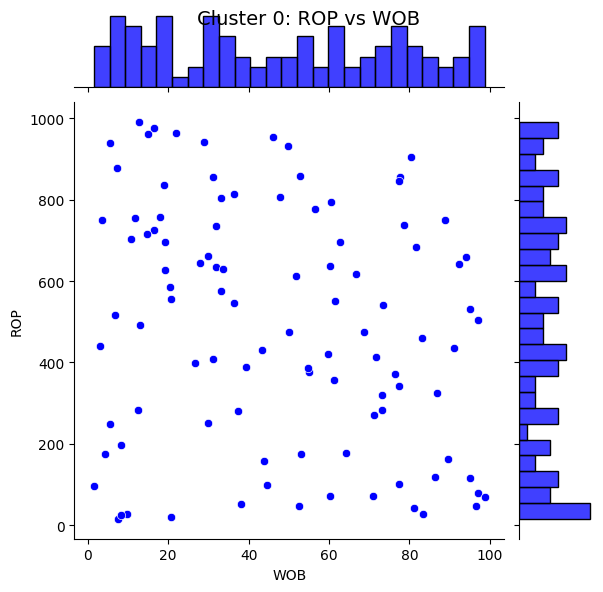

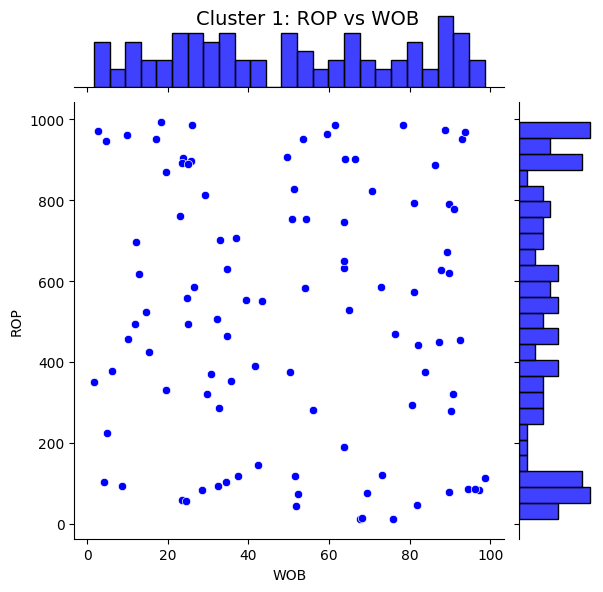

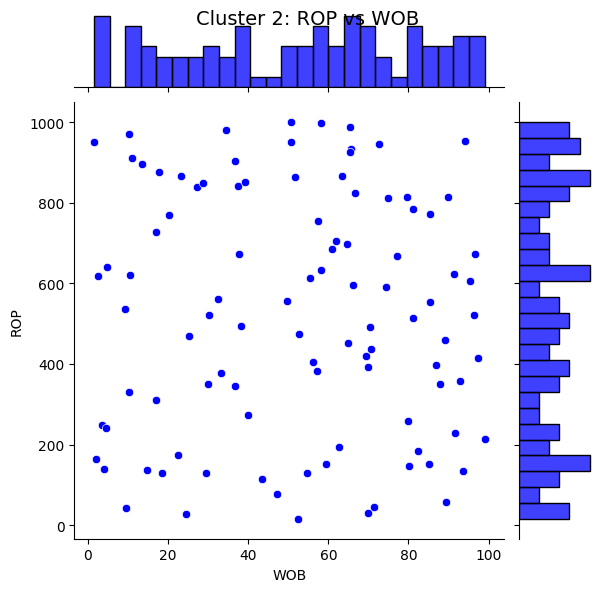

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example DataFrame structure
# df = pd.DataFrame({
#     'WOB': [data for your WOB values],
#     'ROP': [data for your ROP values],
#     'cluster': [data for your cluster labels]
# })

# Loop through each cluster to create a joint plot
for cluster in df['cluster'].unique():
    # Filter the DataFrame for the current cluster
    cluster_data = df[df['cluster'] == cluster]

    # Create the joint plot
    # Note: Seaborn's version at the time of writing this does not support 'hue' in jointplot for scatter plots.
    # Therefore, we will create separate plots for each cluster.
    g = sns.jointplot(x='WOB', y='ROP', data=cluster_data, kind="scatter",
                      color="blue", marginal_kws=dict(bins=25, fill=True))

    # Customize the plot title
    g.fig.suptitle(f'Cluster {cluster}: ROP vs WOB', fontsize=14)

    # Show the plot
    plt.show()

In [15]:
plot_3d_scatter(df, 'WOB_AVG__kLbf', 'TORQ_AVG__kLbf.ft', 'DOC__in/rev')

In [17]:
plot_3d_scatter(df, 'DOC__in/rev', 'TORQ_AVG__kLbf.ft', 'MSE__ksi')

In [24]:
# Read data_original
df = read_and_process_file("../data_to_work/G7.csv")
print("Complete Read File")

df = clean_df(df, ['ROPA_AVG__m/h', 'BITRPM_AVG__rpm',
              'DOC__in/rev', 'TORQ_AVG__kLbf.ft', 'WOB_AVG__tf'])
df = remove_outliers(df, ['DOC__in/rev', 'TORQ_AVG__kLbf.ft'])

plot_2d_scatter(df, x_col='WOB_AVG__tf', y_col='ROPA_AVG__m/h', marker_size=7)

Index(['DEPMD__m', 'WOB_AVG__tf', 'DEPTVD__m', 'ROPA_AVG__m/h',
       'TORQ_AVG__kLbf.ft', 'SURFRPM_AVG__rpm', 'MOTORRPM_AVG__rpm',
       'BITRPM_AVG__rpm', 'SPP_AVG__Psi', 'CHKP_AVG__Psi', 'CEMENTP_AVG__Psi',
       'SPM01_AVG__Stk/min', 'SPM02_AVG__Stk/min', 'SPM03_AVG__Stk/min',
       'PITACTIVE_AVG__bbl', 'FLOWIN_AVG__gal/min', 'FLOWOUTP_AVG__%',
       'DIN_AVG__ppg', 'TIN_AVG__C', 'DOUT_AVG__ppg', 'TOUT_AVG__C', 'HP__hp',
       'DOC__in/rev', 'MSE__ksi', 'Comments__TOC/TOP', 'well'],
      dtype='object')
Complete Read File


In [25]:
plot_3d_scatter(df, 'WOB_AVG__tf', 'TORQ_AVG__kLbf.ft',
                'DOC__in/rev')

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\phamsonn\Anaconda3\envs\funix_DL\li

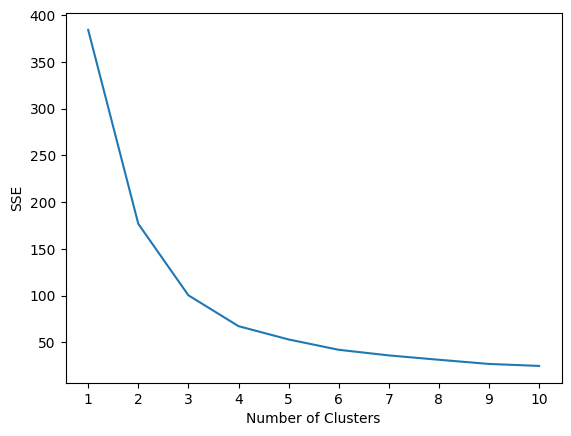

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Index(['DEPMD__m', 'WOB_AVG__tf', 'DEPTVD__m', 'ROPA_AVG__m/h',
       'TORQ_AVG__kLbf.ft', 'SURFRPM_AVG__rpm', 'MOTORRPM_AVG__rpm',
       'BITRPM_AVG__rpm', 'SPP_AVG__Psi', 'CHKP_AVG__Psi', 'CEMENTP_AVG__Psi',
       'SPM01_AVG__Stk/min', 'SPM02_AVG__Stk/min', 'SPM03_AVG__Stk/min',
       'PITACTIVE_AVG__bbl', 'FLOWIN_AVG__gal/min', 'FLOWOUTP_AVG__%',
       'DIN_AVG__ppg', 'TIN_AVG__C', 'DOUT_AVG__ppg', 'TOUT_AVG__C', 'HP__hp',
       'DOC__in/rev', 'MSE__ksi', 'Comments__TOC/TOP', 'well', 'cluster'],
      dtype='object')

In [26]:
df = perform_kmeans(df, ['WOB_AVG__tf', 'TORQ_AVG__kLbf.ft',
                         'DOC__in/rev'])
plot_3d_scatter(df, 'WOB_AVG__tf', 'TORQ_AVG__kLbf.ft',
                'DOC__in/rev', 'cluster')
df.to_csv('data_original_cluster.csv', index=None)
df.columns

In [27]:
plot_3d_scatter(df, 'DOC__in/rev', 'TORQ_AVG__kLbf.ft',
                'MSE__ksi', color_col='cluster')

In [32]:
# Optimizing parameters
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize
import numpy as np


def monte_carlo_optimization(data, iterations=100):
    results = []
    for _ in range(iterations):
        # Random initial guess within bounds
        initial_guess = [
            np.random.uniform(lower_bound_WOB, upper_bound_WOB),
            np.random.uniform(lower_bound_RPM, upper_bound_RPM),
            np.random.uniform(lower_bound_Torque, upper_bound_Torque),
            np.random.uniform(lower_bound_ROPA_AVG, upper_bound_ROPA_AVG)
        ]
        result = minimize(
            objective_function,
            initial_guess,
            method='L-BFGS-B',
            bounds=bounds
        )
        results.append((result.x, -result.fun))

    # Analyze the results to find ranges
    optimized_params = np.array([res[0] for res in results])
    mse_values = np.array([res[1] for res in results])

    # Determine the range of parameters for the lower MSE values
    low_mse_indices = mse_values <= np.percentile(
        mse_values, 10)  # Adjust percentile as needed
    low_mse_params = optimized_params[low_mse_indices]

    return low_mse_params, mse_values[low_mse_indices]


# Then you can call this function for each cluster
for cluster in original_data['cluster'].unique():
    clustered_data = original_data[original_data['cluster'] == cluster]
    low_mse_params, low_mses = monte_carlo_optimization(clustered_data)

    # Process the low_mse_params to find the range of parameters
    param_ranges = {
        'WOB': (low_mse_params[:, 0].min(), low_mse_params[:, 0].max()),
        'RPM': (low_mse_params[:, 1].min(), low_mse_params[:, 1].max()),
        'Torque': (low_mse_params[:, 2].min(), low_mse_params[:, 2].max()),
        'ROPA_AVG': (low_mse_params[:, 3].min(), low_mse_params[:, 3].max()),
    }

    print(f'Cluster: {cluster}')
    print(f'Parameter Ranges for Low MSE:')
    for param, (low, high) in param_ranges.items():
        print(f'{param}: {low:.2f} to {high:.2f}')
    print(
        f'Corresponding MSE Range: {low_mses.min():.2f} to {low_mses.max():.2f}')
    print()

NameError: name 'objective_function' is not defined

### Normalize data

In [49]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the dataset
data_path = 'data_original_cluster.csv'
original_data = pd.read_csv(data_path)

# Select features for normalization
# Assuming that these are the features in the dataset that we want to normalize
# (based on the provided code snippet)
features_to_normalize = ['WOB_AVG__tf',
                         'BITRPM_AVG__rpm', 'TORQ_AVG__kLbf.ft', 'ROPA_AVG__m/h']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the features and transform
original_data[features_to_normalize] = scaler.fit_transform(
    original_data[features_to_normalize])

# Check the first few rows of the dataset to confirm normalization
normalized_data_head = original_data.head()

normalized_data_head

,DEPMD__m,WOB_AVG__tf,DEPTVD__m,ROPA_AVG__m/h,TORQ_AVG__kLbf.ft,SURFRPM_AVG__rpm,MOTORRPM_AVG__rpm,BITRPM_AVG__rpm,SPP_AVG__Psi,CHKP_AVG__Psi,...,FLOWOUTP_AVG__%,DIN_AVG__ppg,TIN_AVG__C,DOUT_AVG__ppg,TOUT_AVG__C,HP__hp,DOC__in/rev,MSE__ksi,Comments__TOC/TOP,cluster
0,2671,5.428037,2536.87,-1.244065,-2.344917,48,0,-5.385028,676,0,...,24.95,11.69,38.025,11.69,34.7,41.492765,0.748852,8.20,TOC,0
1,2687,0.191640,2550.40,-0.536158,-1.805236,48,0,-5.385028,862,0,...,24.58,11.69,40.323,11.69,34.4,43.594821,0.887741,7.19,TOC,1
2,2688,0.169545,2551.26,-0.580750,-1.875630,48,0,-5.385028,865,0,...,23.81,11.69,40.254,11.70,34.5,43.320640,0.878992,7.22,TOC,1
3,2689,0.169545,2552.10,-0.456031,-1.899094,48,0,-5.385028,865,0,...,25.21,11.69,40.191,11.70,34.5,43.229246,0.903461,7.01,TOC,1
4,2690,0.169545,2552.95,-0.428160,-1.946023,48,0,-5.385028,866,0,...,24.93,11.69,40.136,11.70,34.6,43.046458,0.908929,6.94,TOC,1


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Selecting the target variable based on the provided code snippet
target_variable = 'MSE__ksi'

# Splitting the dataset into features and target variable
X = original_data[features_to_normalize]
y = original_data[target_variable]

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Initializing models
linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
knn_model = KNeighborsRegressor()
svm_model = SVR()

# Dictionary to store models and their names
models = {
    'Linear Regression': linear_model,
    'Ridge Regression': ridge_model,
    'K-Nearest Neighbors': knn_model,
    'Support Vector Machine': svm_model
}

# Dictionary to store results
results = {}

# Training and evaluating each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    # Store results
    results[model_name] = mse

results

{'Linear Regression': 0.32707822340174336,
 'Ridge Regression': 0.3261305804717096,
 'K-Nearest Neighbors': 0.10426977083333326,
 'Support Vector Machine': 0.09170705939913572}

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load your dataset
data = pd.read_csv('data_original_cluster.csv')

# Assuming your dataset is already loaded and is named 'data'
# And assuming 'cluster' is the column with cluster identifiers

# Define the bounds for your parameters (example bounds given)
bounds = [(1, 20), (20, 200), (1, 20), (1, 300)]

# Normalize the features
scaler = StandardScaler()
features = ['WOB_AVG__tf', 'BITRPM_AVG__rpm',
            'TORQ_AVG__kLbf.ft', 'ROPA_AVG__m/h']
data[features] = scaler.fit_transform(data[features])

# Define the model architecture


def build_model(input_shape):
    model = Sequential([
        Dense(64, input_dim=input_shape, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# Function to optimize the MSE for a given cluster


def optimize_cluster(cluster_data, bounds):
    # Splitting the data
    X = cluster_data[features]
    y = cluster_data['MSE__ksi']

    # Further split the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Build and train the model
    model = build_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    # Define the objective function for the optimizer to minimize
    def objective(params):
        params = np.array(params).reshape(1, -1)
        params = scaler.transform(params)  # Make sure to scale the parameters
        prediction = model.predict(params)
        return prediction[0][0]

    # Perform optimization
    result = minimize(objective, x0=X.mean().tolist(),
                      bounds=bounds, method='L-BFGS-B')

    # Scale back the optimized parameters to their original scale
    optimized_params = scaler.inverse_transform(
        np.array(result.x).reshape(1, -1))

    # Evaluate the model with optimized parameters
    min_mse = objective(result.x)

    return optimized_params.flatten().tolist(), min_mse


# Dictionary to hold optimization results for each cluster
optimization_results = {}

# Loop over each cluster to optimize
for cluster in data['cluster'].unique():
    cluster_data = data[data['cluster'] == cluster]
    params, min_mse = optimize_cluster(cluster_data, bounds)
    optimization_results[cluster] = {'Parameters': params, 'Min MSE': min_mse}

# Print the optimization results for each cluster
for cluster, results in optimization_results.items():
    print(
        f"Cluster: {cluster}, Optimized Parameters: {results['Parameters']}, Min MSE: {results['Min MSE']}")

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



1/1 [==============================] - 0s 30ms/step


c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



1/1 [==============================] - 0s 29ms/step


c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



1/1 [==============================] - 0s 83ms/step


c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



1/1 [==============================] - 0s 28ms/step


c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



1/1 [==============================] - 0s 34ms/step


c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



Cluster: 0, Optimized Parameters: [1.675864886804223, 175.07635204481466, 5.96552913122378, 86.98717660902193], Min MSE: 16.23601722717285
Cluster: 1, Optimized Parameters: [1.675864886804223, 175.07635204481466, 5.96552913122378, 86.98717660902193], Min MSE: 23.108173370361328


In [46]:
# !pip install scikit-optimize
from math import pi
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Conversion factors
uk_ton_to_lbm = 2240
m_to_ft = 3.28084

# Function to convert units


def convert(value, from_unit, to_unit):
    if from_unit == "uk_ton" and to_unit == "lbm":
        return value * uk_ton_to_lbm
    elif from_unit == "m" and to_unit == "ft":
        return value * m_to_ft
    else:
        raise ValueError(
            "Conversion from {} to {} not implemented.".format(from_unit, to_unit))

# Define the space of hyperparameters to optimize
space = [Real(lower_bound_WOB, upper_bound_WOB, name='WOB'),
         Real(lower_bound_RPM, upper_bound_RPM, name='RPM'),
         Real(lower_bound_Torque, upper_bound_Torque, name='Torque'),
         Real(lower_bound_ROPA_AVG, upper_bound_ROPA_AVG, name='ROPA_AVG')]

# Define the objective function
@use_named_args(space)
def objective(WOB, RPM, Torque, ROPA_AVG):
    # Convert WOB from UK tons to lbm and ROP from m to ft
    WOB_lbm = convert(WOB, "uk_ton", "lbm")
    ROP_ft = convert(ROPA_AVG, "m", "ft")

    # Calculate MSE in ksi
    MSE = WOB_lbm / (pi * 4.25 * 4.25 * 1000) + 480 * \
        Torque * RPM / (8.5 * 8.5 * ROP_ft)
    return MSE


# Run the optimization
res_gp = gp_minimize(objective, space, n_calls=100, random_state=0)

# Print the found minimum
print("Best MSE=%.4f" % res_gp.fun)
print("Best parameters:")
for param, val in zip(['WOB', 'RPM', 'Torque', 'ROPA_AVG'], res_gp.x):
    print(f"{param}: {val:.4f}")

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Best MSE=0.1745
Best parameters:
WOB: 1.0000
RPM: 20.0000
Torque: 1.0000
ROPA_AVG: 300.0000


In [120]:
# import data_wrangling.xlsx as df
df = pd.read_excel('data_wrangling.xlsx')

# print out column names in df
print(df.columns)

df = clean_df(df, ['ROPA_AVG__m/h', 'BITRPM_AVG__rpm'])
df = remove_outliers(df, 'DOC__in/rev')
df = remove_outliers(df, 'TORQ_AVG__kLbf.ft')
plot_3d_scatter(df, 'WOB_AVG__tf ', 'TORQ_AVG__kLbf.ft',
                'DOC__in/rev', 'Comments__TOC/TOP')
plot_3d_scatter(df, 'DOC__in/rev', 'TORQ_AVG__kLbf.ft',
                'MSE__psi', 'DEPMD__m')

Index(['DEPMD__m', 'WOB_AVG__tf ', 'DEPTVD__m', 'ROPA_AVG__m/h',
       'TORQ_AVG__kLbf.ft', 'SURFRPM_AVG__rpm', 'MOTORRPM_AVG__rpm',
       'BITRPM_AVG__rpm', 'SPP_AVG__Psi', 'CHKP_AVG__Psi', 'CEMENTP_AVG__Psi',
       'SPM01_AVG__Stk/min', 'SPM02_AVG__Stk/min', 'SPM03_AVG__Stk/min',
       'PITACTIVE_AVG__bbl', 'FLOWIN_AVG__gal/min', 'FLOWOUTP_AVG__%',
       'DIN_AVG__ppg', 'TIN_AVG__C', 'DOUT_AVG__ppg', 'TOUT_AVG__C', 'HP__hp',
       'MSE__psi', 'Comments__TOC/TOP', 'DOC__in/rev'],
      dtype='object')


In [124]:
df = perform_kmeans(df, ['WOB_AVG__tf ', 'TORQ_AVG__kLbf.ft',
                         'DOC__in/rev'], k=2)
plot_3d_scatter(df, 'WOB_AVG__tf ', 'TORQ_AVG__kLbf.ft',
                'DOC__in/rev', 'cluster')

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [10]:
df['MSE__ksi'] = pd.to_numeric(df['MSE__ksi'], errors='coerce')
df['MSE__ksi'] = df['MSE__ksi'].round(2)
plot_3d_scatter(df, 'DOC__in/rev', 'TORQ_AVG__kLbf.ft',
                'MSE__ksi', 'cluster')

In [82]:
# Read the file with no header
df = pd.read_csv('drilling_ucs.csv', header=None)

# Combine the first two rows to create the header
header = df.iloc[0].str.strip() + '__' + df.iloc[1].str.strip()

# Remove the first two rows
df = df.iloc[2:]

# Set the new header
df.columns = header

# Print out the new column names
print(df.columns)

Index(['Depth__m', 'DCAV__in', 'UCS-CA__psi', 'UCS-BD__psi', 'GR__gapi',
       'P40H__ohm.m', 'WOBA__klbm', 'RPMS__1/min', 'TQA__klbf.ft', 'ROPA__m/h',
       'DOC__in/rev', 'MSE__ksi'],
      dtype='object')


In [90]:
df = read_and_process_file('drilling_ucs.csv')
df = clean_df(df, ['ROPA__m/h', 'RPMS__1/min',
              'DOC__in/rev', 'TQA__klbf.ft', 'WOBA__klbm', 'Depth__m', 'MSE__ksi', 'UCS-BD__psi'])
df = clean_df(df, ['ROPA__m/h', 'RPMS__1/min',
              'DOC__in/rev', 'TQA__klbf.ft', 'WOBA__klbm', 'UCS-BD__psi'])
df = remove_outliers(df, 'DOC__in/rev')
df = remove_outliers(df, 'TQA__klbf.ft')
plot_3d_scatter(df, 'DOC__in/rev', 'TQA__klbf.ft',
                'MSE__ksi', 'UCS-BD__psi', 'WOBA__klbm')

In [87]:
plot_2d_scatter(df, 'DOC__in/rev', 
                'MSE__ksi', 'Depth__m', 'WOBA__klbm')

In [114]:
df = read_and_process_file('hard_stringers.csv')
df = clean_df(df, ['ROP5__m/h', 'RPM__c/min',
              'DOC__in/rev', 'STOR__kN.m', 'SWOB__1000', 'Depth__m', 'MSE__ksi', 'P40H#1__ohm.m'])
df = remove_outliers(df, 'DOC__in/rev')
df = remove_outliers(df, 'STOR__kN.m')
df = remove_outliers(df, 'SWOB__1000')
df = remove_outliers(df, 'P40H#1__ohm.m')
df = df[df['SWOB__1000']>0]
plot_3d_scatter(df, x_col='DOC__in/rev', y_col='STOR__kN.m',
                z_col='MSE__ksi', color_col='Depth__m', marker_size=3)
plot_3d_scatter(df, x_col='SWOB__1000', y_col='STOR__kN.m',
                z_col='DOC__in/rev', color_col='P40H#1__ohm.m', marker_size=3)

Index(['Depth__m', 'ROP5__m/h', 'STOR__kN.m', 'SWOB__1000', 'RPM__c/min',
       'CRPM__c/min', 'STICK__c/min', 'SPPA__psi', 'TFLO__gal/min',
       'DHAP__psi', 'VIB_X__gn', 'VIB_LAT__gn', 'SHKRSK__', 'SHKL__',
       'P40H#1__ohm.m', 'GR#1__gAPI', 'MSE__ksi', 'DOC__in/rev'],
      dtype='object')


## Parking Slot

In [ ]:
def plot_3d_scatter(df, x_col, y_col, z_col, color_col=None, size_col=None, width=800, height=800, marker_size=3, num_ticks=5):
    color = df[color_col] if color_col else None

    fig = go.Figure(data=[go.Scatter3d(
        x=df[x_col],
        y=df[y_col],
        z=df[z_col],
        mode='markers',
        marker=dict(
            size=marker_size,
            color=color,
            colorscale='Viridis',
            opacity=0.8
        )
    )])

    # Calculate dtick values for each axis
    x_dtick = (df[x_col].max() - df[x_col].min()) / num_ticks
    y_dtick = (df[y_col].max() - df[y_col].min()) / num_ticks
    z_dtick = (df[z_col].max() - df[z_col].min()) / num_ticks

    fig.update_layout(scene=dict(
        xaxis_title=x_col,
        yaxis_title=y_col,
        zaxis_title=z_col,
        xaxis=dict(
            tickmode='linear',
            tick0=0,
            dtick=x_dtick,
            tickformat=".2f",
            range=[0, df[x_col].max()]),  # Set min value to 0
        yaxis=dict(
            tickmode='linear',
            tick0=0,
            dtick=y_dtick,
            tickformat=".2f",
            range=[0, df[y_col].max()]),  # Set min value to 0
        zaxis=dict(
            tickmode='linear',
            tick0=0,
            dtick=z_dtick,
            tickformat=".2f",
            range=[0, df[z_col].max()]),  # Set min value to 0
    ),
        width=700,
        margin=dict(r=20, b=10, l=10, t=10))

    fig.show()